# Example of how to fit spectra using species 

This tutorial shows how to use ```fitspec``` which uses the ```species``` package to fit NIR low resolution spectra.  We will use a NIR spectra (0.9-2.5μm) from SOAR/TripleSpec of the brown dwarf 2MASS J11011926-7732383. The data are currently published in Betti (2023) https://ui.adsabs.harvard.edu/abs/2023PhDT........13B/abstract 


The main functionality of ```fitspec```: 
- fit empirical spectra
- fit models
- calculate uncertainties on best fit models 

## Getting started

First download and install ```species``` from https://species.readthedocs.io/en/latest/installation.html if you do not have it downloaded.  You must also have ```pymultinest``` installed: https://johannesbuchner.github.io/PyMultiNest/install.html#building-the-libraries

First import Python modules. You should set your ```DYLD_LIBRARY_PATH``` following the ```species``` installation instructions.

written by: Sarah Betti 6-2025

In [1]:
# import warnings
# warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from astropy import units as u
from scipy.stats import binned_statistic
from astropy.io import fits

import os
# CHANGE PATH TO POINT TO YOUR pyMULTINEST installation! 
os.environ['DYLD_LIBRARY_PATH'] = '/Users/sbetti/data/MultiNest/lib'

import bdfit

/Users/sbetti/miniconda3/envs/accretion/lib/python3.11/site-packages/species/fit/fit_model.py:18: UserWarning: UltraNest could not be imported. Perhaps because cython was not correctly compiled?
  warnings.warn(


Determine the path to your spectra and the object name.  The spectra can be in any format because we are going to re-save it in a simple ```.dat``` file.

In [2]:
DATADIR =  '2MASS J11011926-7732383.fits'
OBJ_NAME = '2MASS J11011926-7732383'

# we can chose an optional savename if you want a separate file name.  
savename = '2MASS_J11011926-7732383'

Here, we read the FITS file with ```astropy```.  For simplicity, we bin our data to R~500 and extract the full spectra and the spectra up to 1.9μm.  We only want the real values for fitting (no ```NaN```s or ```INF```s)

We save our data in the format ```{OBJ_NAME}_R{resolution}_short.dat``` (optional) for a sliced spectra and ```{OBJ_NAME}_R{resolution}_full.dat``` (required) for the full spectra.

In [3]:
a = fits.getdata(DATADIR)
wave = a[0]
flux = a[1]
noise = a[2]

binwave = np.arange(wave.min(), wave.max(), 0.005)
FLUX = binned_statistic(wave, flux, statistic='mean', bins=binwave)[0]
NOISE = binned_statistic(wave, flux, statistic='std', bins=binwave)[0]
WAVE = binwave[0:-1]
# only extract real values
idx = np.where(np.isfinite(FLUX))
idx2 = np.where(np.isfinite(FLUX) & (WAVE < 1.9))
np.savetxt(f'{savename}_R500_short.dat', np.c_[WAVE[idx2], FLUX[idx2], NOISE[idx2]])
np.savetxt(f'{savename}_R500_full.dat', np.c_[WAVE[idx], FLUX[idx], NOISE[idx]])

We now determine the parallax.  This is necessary for proper fitting of the object radius. We show a couple of different ways to get this value:
1. using astroquery.simbad
2. using CASPAR (Betti+2023) 
     - CASPAR (Comprehensive Archive of Substelalr and Planetary Accretion Rates) is an archive of accretion and stellar properties for accreting objects.
     
Method using simbad

In [4]:
from astroquery.simbad import Simbad
simbad = Simbad()
simbad.add_votable_fields("parallax")
result_table = simbad.query_object(OBJ_NAME)

PARALLAX = result_table['PLX_VALUE'][0]
PARALLAX_err = result_table['PLX_ERROR'][0]
print(PARALLAX, PARALLAX_err)
result_table[['MAIN_ID', 'PLX_VALUE', 'PLX_ERROR']]

-- --


MAIN_ID,PLX_VALUE,PLX_ERROR
,mas,mas
object,float64,float32
2MASS J11011926-7732383,--,--


Method using CASPAR.  
first download the CASPAR google sheet if you do not already have it. 

In [5]:
import gdown
url = 'https://drive.google.com/uc?id=1QbJHcrndhaP2JIrBazy4zcUULpgClCdt76nMilKfRNs'
output = "caspar.xlsx"
gdown.download(url, output)

Downloading...
From (original): https://drive.google.com/uc?id=1QbJHcrndhaP2JIrBazy4zcUULpgClCdt76nMilKfRNs
From (redirected): https://docs.google.com/spreadsheets/d/1QbJHcrndhaP2JIrBazy4zcUULpgClCdt76nMilKfRNs/export?format=xlsx
To: /Users/sbetti/Documents/Science/NIRAccretion/TSpec/bdfit/example/caspar.xlsx
3.99MB [00:00, 22.8MB/s]


'caspar.xlsx'

In [6]:
caspar = pd.read_excel('caspar.xlsx', sheet_name='Literature Database', skiprows=[1])
caspar['Mass jup'] = (np.array(caspar['Mass'].values)*u.Msun).to(u.Mjup).value
caspar['Radius jup'] = (np.array(caspar['Radius'].values)*u.Rsun).to(u.Rjup).value
caspar_obj = caspar[['Reference Name','GAIA EDR3 Parallax', 'GAIA EDR3 Parallax err', 'A_V', 'Teff', 'Mass','Mass jup', 'Radius jup']].loc[caspar['Reference Name']==OBJ_NAME]


PARALLAX = caspar_obj['GAIA EDR3 Parallax'].values[0]
PARALLAX_err = caspar_obj['GAIA EDR3 Parallax err'].values[0]

print(PARALLAX, PARALLAX_err)
caspar_obj

5.3603 0.149


,Reference Name,GAIA EDR3 Parallax,GAIA EDR3 Parallax err,A_V,Teff,Mass,Mass jup,Radius jup
204,2MASS J11011926-7732383,5.3603,0.149,1.59,2838.0,0.05,52.378276,5.741384


## Using ```fitspec```

We are going to use our R~500 spectra and find the best fit parameters that describe our spectra.  We will create an instance of ```fitspec``` by providing the OBJ_NAME, PARALLAX, PARALLAX_err, spectral resolution (spec_res), the short and full paths to our saved spectra (specfile_short_name, specfile_full_name), and the model library of choice from species.  

Note that the spectral resolution MUST be a float (e.g. ```500.```).  And integer will cause ```species``` to fail. 


If you created a shorted spectra, then you should call both the short and full versions into ```fitspec```.  Further down, there will be an attribute variable called ```spec_length```.  This indicates which spectra will be used for that attribute.  The options are "short" or "full". 

In [7]:

fs = bdfit.fitspec(OBJ_NAME, PARALLAX, PARALLAX_err, 
                   specfile_short_name=f'{savename}_R500_short.dat',
                   specfile_full_name=f'{savename}_R500_full.dat',
                       spec_res=500., model='bt-settl-cifist', 
                  save_name=savename)


species

Version: 0.9.1.dev71+g96da3de.d20250528
Working folder: /Users/sbetti/Documents/Science/NIRAccretion/TSpec/bdfit/example

Configuration file: /Users/sbetti/Documents/Science/NIRAccretion/TSpec/bdfit/example/species_config.ini
Database file: species_database.hdf5
Data folder: data

Configuration settings:
   - Database: species_database.hdf5
   - Data folder: data
   - Magnitude of Vega: 0.03

Multiprocessing: mpi4py not installed

----------
Add object
----------

Object name: 2MASS J11011926-7732383
Units: None
Deredden: None
Parallax (mas) = 5.36 +/- 0.15

Spectra:
   - Spectrum:
      - Database tag: 2MASS J11011926-7732383_short
      - Filename: 2MASS_J11011926-7732383_R500_short.dat
      - Data shape: (157, 3)
      - Wavelength range (um): 0.95 - 1.81
      - Mean flux (W m-2 um-1): 6.43e-15
      - Mean error (W m-2 um-1): 2.37e-16
   - Spectrum:
      - Database tag: 2MASS J11011926-7732383_full
      - Filename: 2MASS_J11011926-7732383_R500_full.dat
      - Data sha

###  Empirical template fitting 

First, we find the best fit emprical template from spex and Bonnefoy+2014 for our spectra.  We chose the library (e.g. ```spec``` or ```bonnefoy+2014```) from the list of available ```species``` libraries.  We next chose which part of the spectra to fit the library to: ```spec_length = 'short'``` and ```wavel_range=(0.9,1.9)```.  We can also select which spectral types we want to look through, the range of Av to test against.  Finally, we have optional kwargs for plotting.  The label position refers to the position of the bottom most label in the figure. 


--------------------
Add spectral library
--------------------

Database tag: spex
Spectral types: ['M']
Adding spectra... [DONE]                      
Processing spectra... [DONE]                      
Best-fitting spectra:
    1. G = 8.82e+01 -> 2MASS J11395113-3159214, M9, A_V = 0.80, RV = 0 km/s,
                       scalings = [0.37190031]
    2. G = 9.66e+01 -> MHO 4, M7, A_V = 2.70, RV = 0 km/s,
                       scalings = [0.19089638]
    3. G = 9.76e+01 -> 2MASS J04414825+2534304, M7, A_V = 2.20, RV = 0 km/s,
                       scalings = [0.9821969]
    4. G = 1.12e+02 -> CFHT 6, M7, A_V = 2.40, RV = 0 km/s,
                       scalings = [0.42097684]
    5. G = 1.13e+02 -> KPNO 5, M7, A_V = 2.40, RV = 0 km/s,
                       scalings = [0.45182679]
    6. G = 1.14e+02 -> KPNO 2, M7, A_V = 2.40, RV = 0 km/s,
                       scalings = [1.53406654]
    7. G = 1.19e+02 -> CFHT 3, M7, A_V = 2.10, RV = 0 km/s,
                       scalings = [1.017

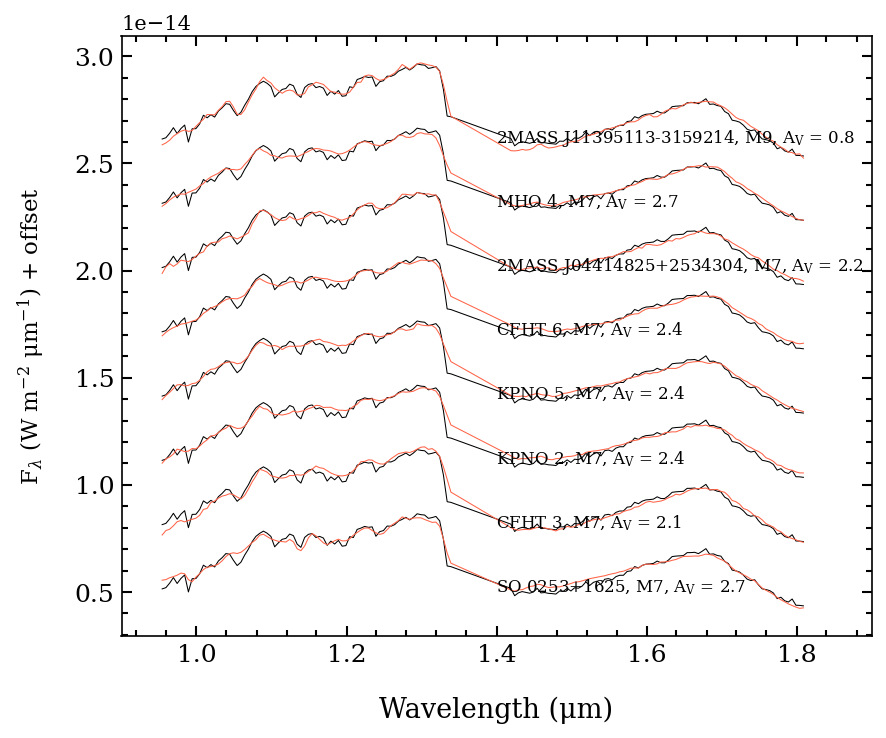

In [8]:
fs.compare_empirical_library('spex', spec_length='short', wavel_range=(0.9,1.9),
                sptypes=['M'],av_range =np.arange(0,5, 0.1),
                xlim = (0.9, 1.9), ylim=None, 
                flux_offset= 3e-15, label_position = (1.4, 0.5e-14),
                            figsize=(5,4))


--------------------
Add spectral library
--------------------

Database tag: bonnefoy+2014
Spectral types: ['M']

Unpacking spectra of young M/L type objects from Bonnefoy et al. 2014 (2.3 MB)... [DONE]

Adding spectra... [DONE]    
Processing spectra... [DONE]    
Best-fitting spectra:
    1. G = 1.64e+03 -> 2M1207A, M8, A_V = 2.10, RV = 0 km/s,
                       scalings = [67969374.41982022]
    2. G = 2.01e+03 -> USco 108 B, M7, A_V = 0.70, RV = 0 km/s,
                       scalings = [1.20445913e+09]
    3. G = 2.04e+03 -> DH Tau B, M9, A_V = 0.00, RV = 0 km/s,
                       scalings = [4.95424589e+08]
    4. G = 3.09e+03 -> OTS 44, M9.5, A_V = 0.00, RV = 0 km/s,
                       scalings = [8.55714554e+08]
    5. G = 3.40e+03 -> KPNO Tau 4, M9.5, A_V = 0.00, RV = 0 km/s,
                       scalings = [2.30476203e+08]
    6. G = 5.49e+03 -> Cha1109, M9, A_V = 0.00, RV = 0 km/s,
                       scalings = [2.07411869e+09]
    7. G = 1.05e+04 -> TW

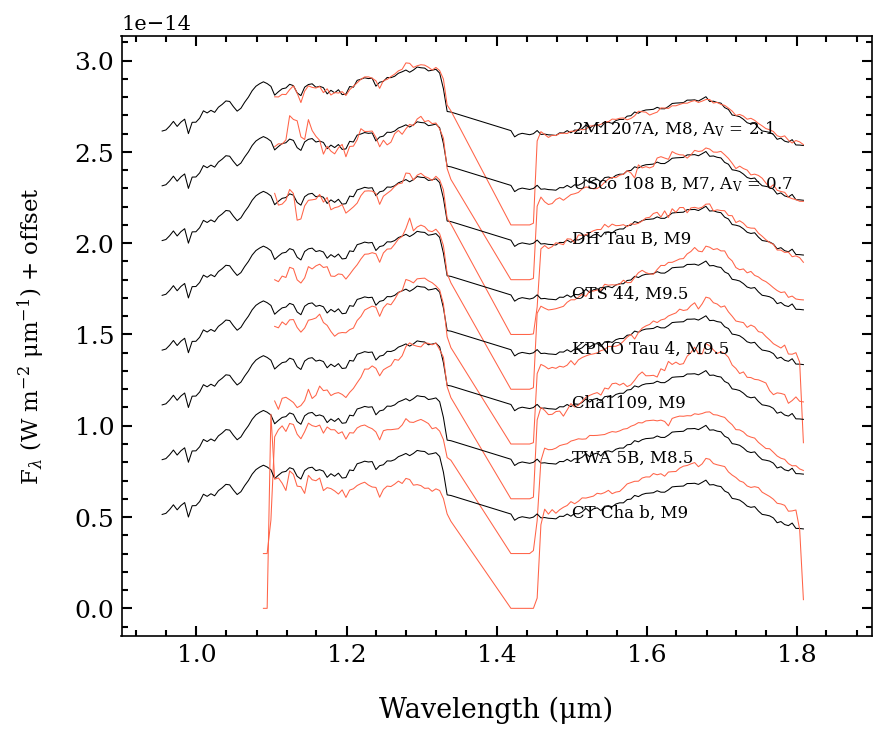

In [9]:
fs.compare_empirical_library('bonnefoy+2014', spec_length='short', wavel_range=(0.9,1.9),
                sptypes=['M'],av_range =np.arange(0,5, 0.1),
                xlim = (0.9, 1.9), ylim=None, 
                flux_offset= 3e-15, label_position = (1.5, 0.5e-14), 
                            figsize=(5,4))

### Spectral Model Grid search

Next, we find the best fit theoretical model for our spectra using a grid search.  The model library was chosen when we initalized the class.  We again chose which part of the spectra to fit the models to: ```spec_length = 'short'``` and ```wavel_range=(0.9,1.9)```.  We can also select which temperature range we want to look through, the range of Av to test against.  Finally, we have optional kwargs for plotting.  The label position refers to the position of the bottom most label in the figure. 


-------------------------
Add grid of model spectra
-------------------------

Database tag: bt-settl-cifist
Model name: BT-Settl CIFIST

Unpacking 53/353 model spectra from BT-Settl CIFIST (442 MB)... [DONE]

Wavelength range (um) = 0.9 - 1.9
Sampling (lambda/d_lambda) = 10000
Teff range (K) = 2100.0 - 2900.0

Adding BT-Settl CIFIST model spectra... data/bt-settl-cifist/bt-settl-cifist_teff_2900_logg_5.5_spec.npy

Grid points stored in the database:
   - Teff = [2100. 2200. 2300. 2400. 2500. 2600. 2700. 2800. 2900.]
   - log(g) = [3.  3.5 4.  4.5 5.  5.5]

Number of grid points per parameter:
   - teff: 9
   - logg: 6

Fix missing grid points with a linear interpolation:
   - teff = 2700.0, logg = 4.0

Number of stored grid points: 54
Number of interpolated grid points: 1
Number of missing grid points: 0
Processing model spectrum 450/450... [DONE]
Best-fit parameters:
   - Goodness-of-fit = 1.03e+02
   - teff = 2700.0
   - logg = 4.0
   - ism_ext = 2.3000000000000003
   - Radius (Rju

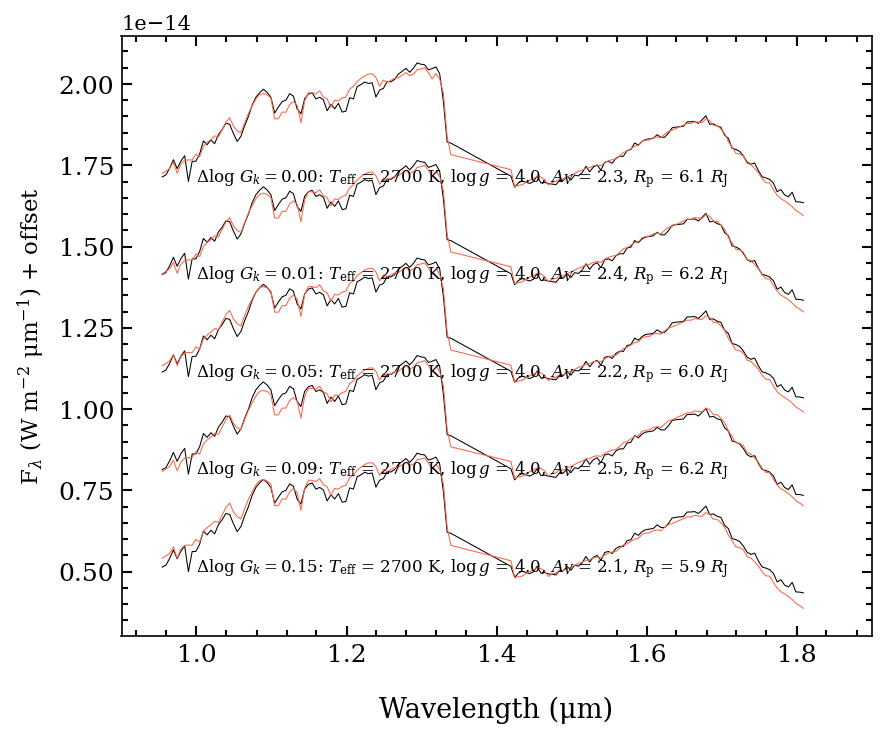

In [10]:
fs.compare_model(spec_length='short', wavel_range=(0.9, 1.9),
              teff_range=(2100., 2900.), av_range=np.arange(0,5,0.1), 
              xlim = (0.9, 1.9), ylim=None, 
              flux_offset= 3e-15, label_position = (1., 0.5e-14),
                figsize=(5,4))

## Model fitting using multinest MCMC

Now we get to the main portion of ```fitspec``` -- the mcmc fitting to the theoretical spectra.  Here, we are using ```species``` multinest fitting.  

We first determine the free paramters and bounds (see ```species``` for which parameters are available.  By using the same value for the beginning and end, the value is held constant.  We again use the short ```spec_length``` as we do not want any excess emission at 2.4 μm to affect the Av estimate.  

The more ```n_live_points``` chosen, the better the fit.  We estimate ~2000 is good for a well populated parameter space.  The ```teff_range``` is the range of temperature range of models and must be equal to or larger than the bounds ```teff```.  In this example we use 100 for computational speed.

In [11]:
bounds = {'teff': (2200,3400),
          'radius': (1, 15),
          'ext_av':(0, 5), 
          'logg':(4.0, 4.0)}
fs.mcmc_fitting(bounds, spec_length='short', n_live_points=100, teff_range=(2100., 3600.))


-------------------------
Add grid of model spectra
-------------------------

Database tag: bt-settl-cifist
Model name: BT-Settl CIFIST

Unpacking 95/353 model spectra from BT-Settl CIFIST (442 MB)... [DONE]

Wavelength range (um) = 0.1 - 5000
Sampling (lambda/d_lambda) = 10000
Teff range (K) = 2100.0 - 3600.0

Adding BT-Settl CIFIST model spectra... data/bt-settl-cifist/bt-settl-cifist_teff_3600_logg_5.5_spec.npy

Grid points stored in the database:
   - Teff = [2100. 2200. 2300. 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200.
 3300. 3400. 3500. 3600.]
   - log(g) = [3.  3.5 4.  4.5 5.  5.5]

Number of grid points per parameter:
   - teff: 16
   - logg: 6

Fix missing grid points with a linear interpolation:
   - teff = 2700.0, logg = 4.0

Number of stored grid points: 96
Number of interpolated grid points: 1
Number of missing grid points: 0

-----------------
Fit model spectra
-----------------

Object name: 2MASS J11011926-7732383
Model tag: bt-settl-cifist
Binary star: Fals

After fitting, we can plot the posterior


---------------------
Get posterior samples
---------------------

Database tag: 2MASS J11011926-7732383
Random samples: None
Samples shape: (425, 5)

Parameters:
   - teff
   - radius
   - parallax
   - ext_av
   - logg

Uniform priors (min, max):
   - ext_av = (0, 5)
   - radius = (1, 15)
   - teff = (2200, 3400)

Normal priors (mean, sigma):
   - parallax = (5.36, 0.15)

----------------------------
Plot posterior distributions
----------------------------

Database tag: 2MASS J11011926-7732383
Object type: planet
Manual parameters: None

Model type: atmosphere
Model name: bt-settl-cifist
Sampler: multinest

Median parameters:
   - teff = 2682.99
   - radius = 6.16
   - parallax = 5.37
   - ext_av = 2.31
   - logg = 4.00

Sample with the maximum likelihood:
   - teff = 2682.99
   - radius = 6.15
   - parallax = 5.37
   - ext_av = 2.31
   - logg = 4.00

Parameters included in corner plot:
   - teff
   - radius
   - parallax
   - ext_av
   - logg
   - log_lum_atm

Output: 2MASS_J1101

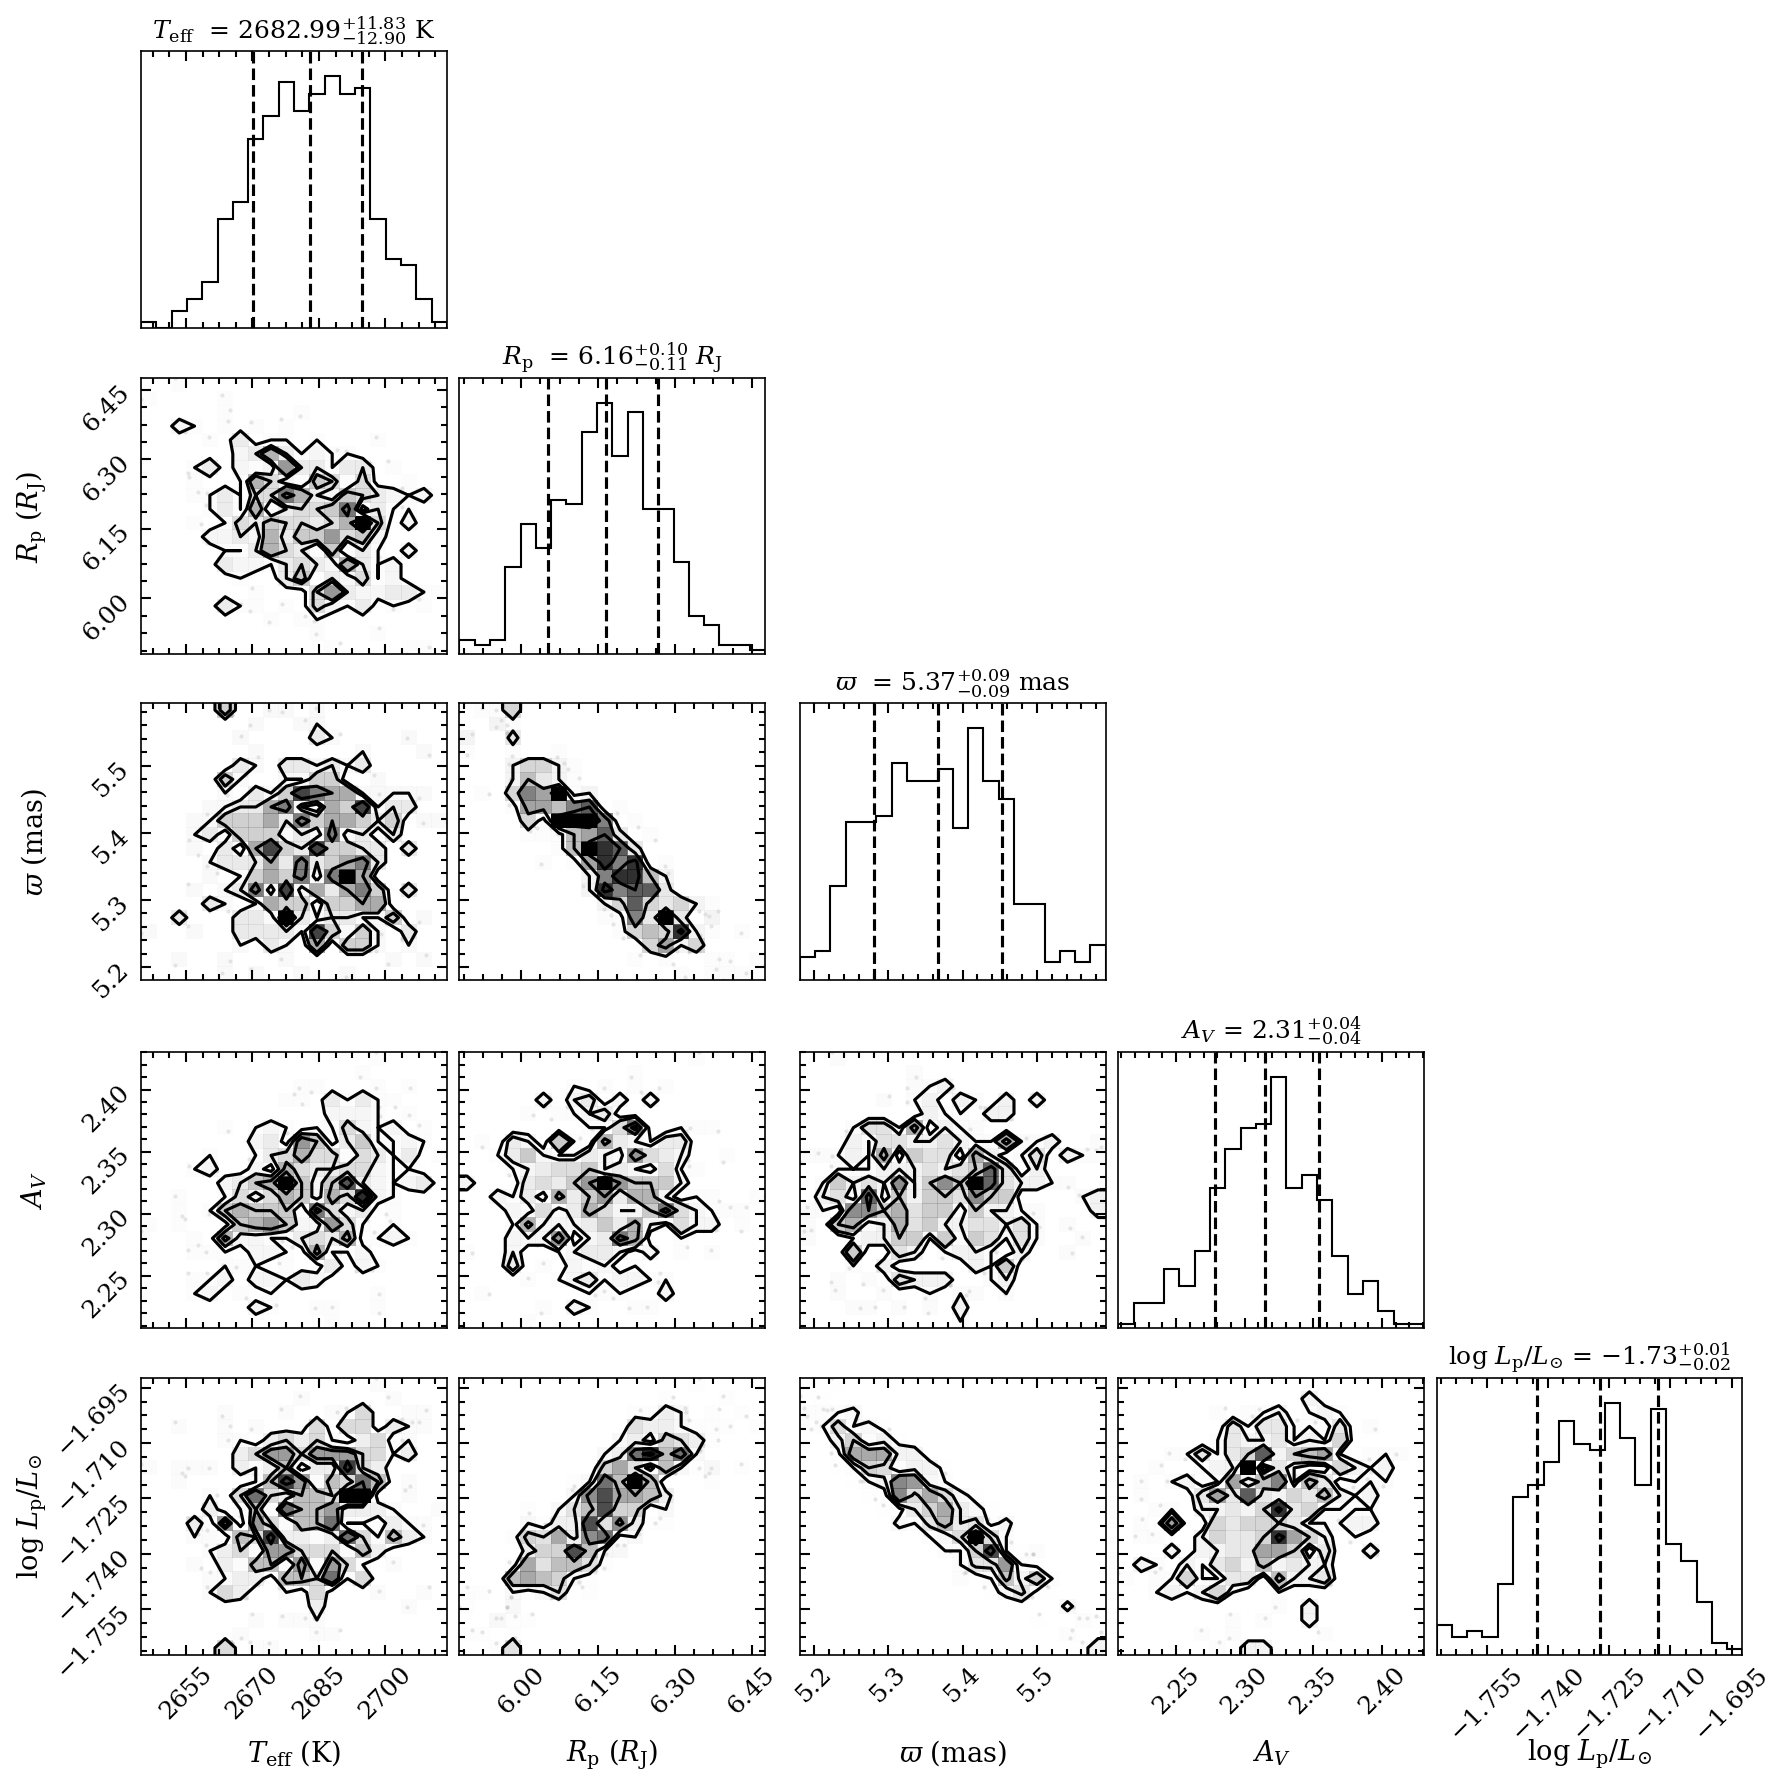

In [12]:
fs.posterior()

Next, we pull out all the posterior samples, the best fit samples (and luminosity), the best fit paramters, and the best fit spectra and residuals.

In [13]:
allsamples, best_parameters, best_model_spec, object_spec, residuals  = fs.all_samples(spec_length='full')
bestsamples = fs.bestfit_samples()


---------------------
Get posterior spectra
---------------------

Database tag: 2MASS J11011926-7732383
Wavelength range (um): None
Resolution: 500.0
Number of samples: 30



  0%|          | 0/30 [00:00<?, ?it/s]


---------------------
Get median parameters
---------------------

Database tag: 2MASS J11011926-7732383

Parameters:
   - teff = 2682.99
   - radius = 6.16
   - parallax = 5.37
   - ext_av = 2.31
   - logg = 4.00

----------
Get object
----------

Object name: 2MASS J11011926-7732383
Include photometry: False
Include spectra: ['2MASS J11011926-7732383_full']

----------------
Update ObjectBox
----------------


-------------------
Calculate residuals
-------------------

Database tag: 2MASS J11011926-7732383
Results type: FitModel
Model: bt-settl-cifist
Binary: False

Model parameters:
   - teff
   - radius
   - parallax
   - ext_av
   - logg

Fixed parameters:
   - logg

Include photometry: False
Include spectra: True

Residuals (sigma):
   - 2MASS J11011926-7732383_full: min = -2.36, max = 3.28

Number of data points = 264
Number of model parameters = 5
Number of fixed parameters = 1
Number of degrees of freedom = 260

chi2 = 236.23
reduced chi2 = 0.91

---------------------
Get po

Now we can plot the best fit model with residuals as well as a nicer "publication" version. We use the full length spectra for the plotting.


-------------
Plot spectrum
-------------

Boxes:
   - List with 30 x ModelBox
   - ModelBox
   - ObjectBox

Object type: planet
Quantity: flux density
Units: ('um', 'W m-2 um-1')
Filter profiles: None

Figure size: (8.0, 4.0)
Legend parameters: None
Include model name: False
Font sizes: {'xlabel': 11.0, 'ylabel': 11.0, 'title': 13.0, 'legend': 9.0}

Output: 2MASS_J11011926-7732383_mcmc_bestfit
continuum residuals for:
J band:  -0.01520717575784425
 H band:  0.03269895056808992
 K band:  0.9184991490538845
JH bands:  -0.01749317929263303


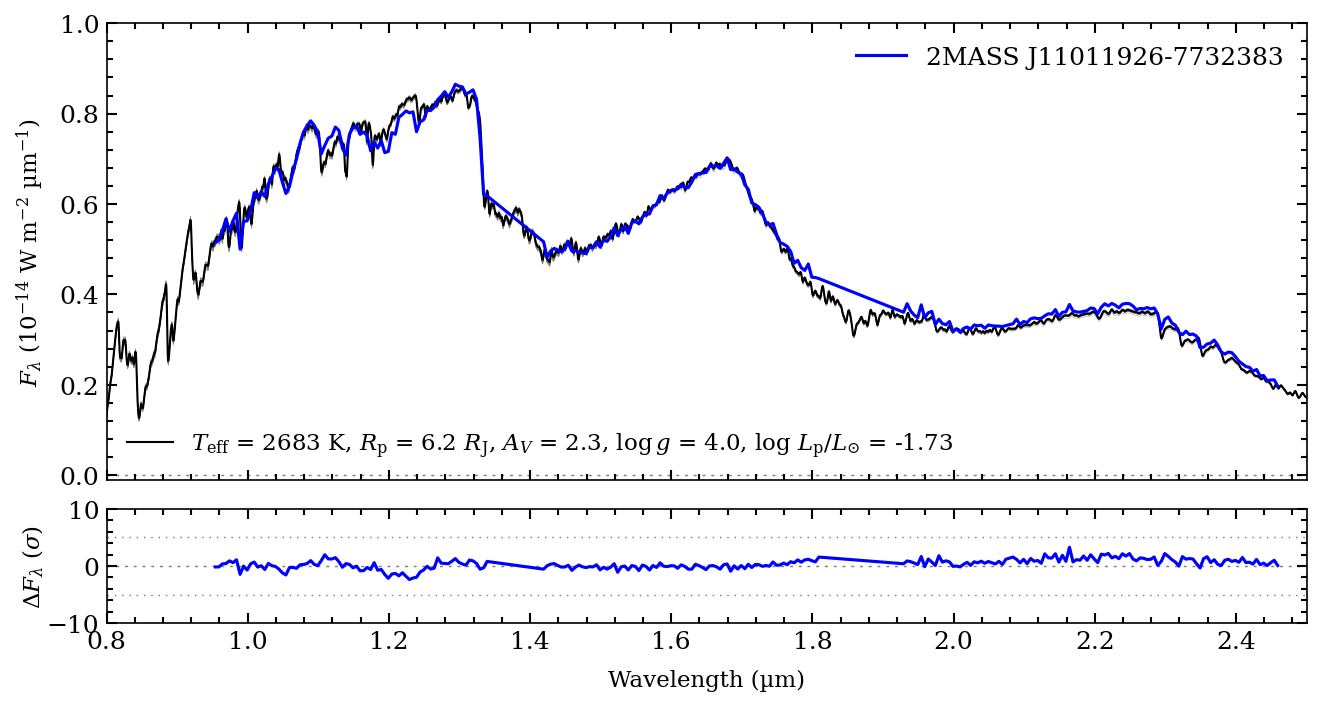

In [14]:
cont_residuals = fs.plot_bestmodel_residual(spec_length='full', 
              xlim=(0.8, 2.5), ylim=(-1.15e-16, 1e-14), label=OBJ_NAME)

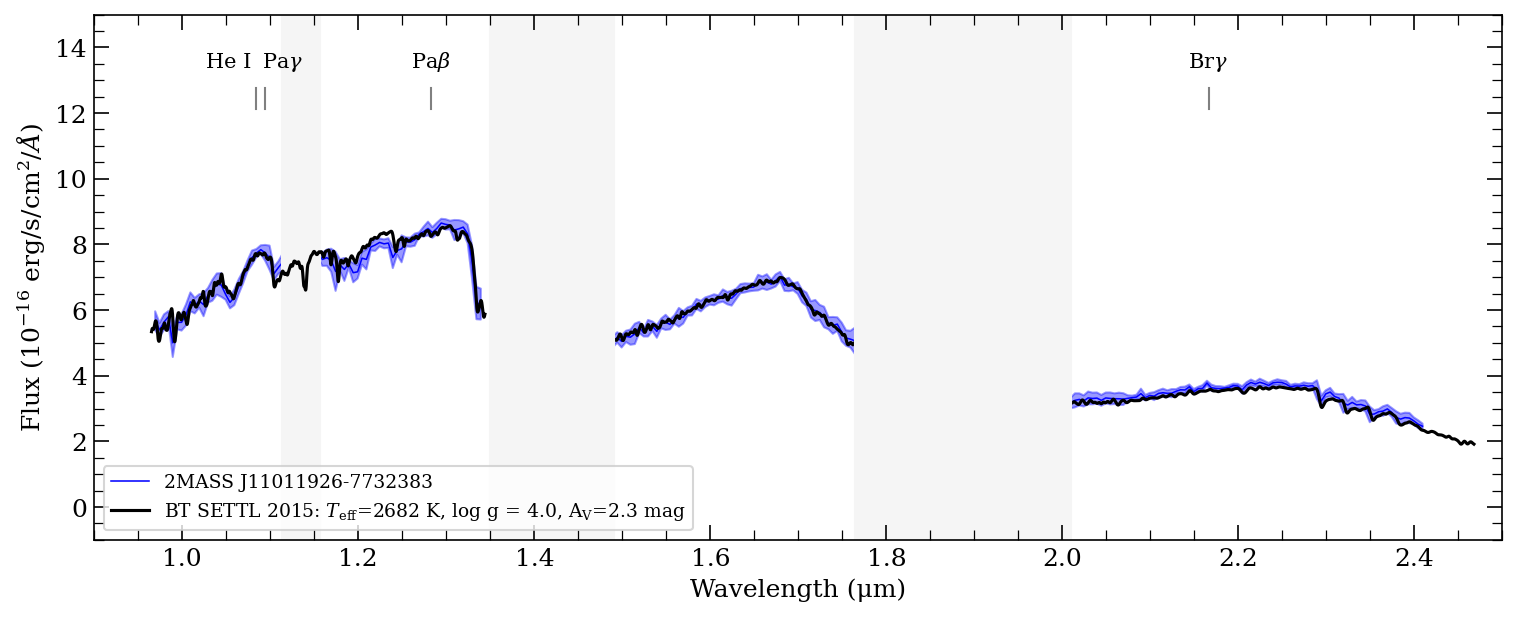

In [15]:
fs.plot_bestmodel(object_spec, best_model_spec, spec_length='full', 
                  wave_unit='um', flux_unit='W/(m2*um)',
                  xlim=(0.9, 2.5), ylim=(-1, 15), normalize_value = 1e-16, fontsize=12,
                  label=OBJ_NAME, figsize=(10,4), plot_waterbands=True, plot_HI=True)

## Compute the Errors on the Parameters. 
```species``` MCMC errors are often underestimated and statistical.  Therefore, we want more robust errors that take into account the grid spacing.  We follow the method of Andrews+2013 (see their Fig.15).  

We know from our grid, the temperature is only known to +/- 100 K.  Therefore, using our best fit Temperature, we determine the best fit parameters when Teff+100 and Teff-100.  Then, the errors on each parameter is the distance from the best fit value to the furthest 68% percentile.  

In [16]:
bounds = {'teff': (2200,3400),
          'radius': (1, 15),
          'ext_av':(0, 5), 
          'logg':(4.0, 4.0)}
plus_samples, plus_vals, minus_samples, minus_vals = fs.compute_errors(bounds, spec_length='short', 
               Teff=None, teff_range=(2100., 3600.), n_live_points=100)


-------------------------
Add grid of model spectra
-------------------------

Database tag: bt-settl-cifist
Model name: BT-Settl CIFIST

Unpacking 95/353 model spectra from BT-Settl CIFIST (442 MB)... [DONE]

Wavelength range (um) = 0.1 - 5000
Sampling (lambda/d_lambda) = 10000
Teff range (K) = 2100.0 - 3600.0

Adding BT-Settl CIFIST model spectra... data/bt-settl-cifist/bt-settl-cifist_teff_3600_logg_5.5_spec.npy

Grid points stored in the database:
   - Teff = [2100. 2200. 2300. 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200.
 3300. 3400. 3500. 3600.]
   - log(g) = [3.  3.5 4.  4.5 5.  5.5]

Number of grid points per parameter:
   - teff: 16
   - logg: 6

Fix missing grid points with a linear interpolation:
   - teff = 2700.0, logg = 4.0

Number of stored grid points: 96
Number of interpolated grid points: 1
Number of missing grid points: 0
>>> changing bound["teff"] from (2200, 3400) to (2782.994602136724, 2782.994602136724)

-------------------------
Add grid of model spect

best fit Teff =  2682.994602136724


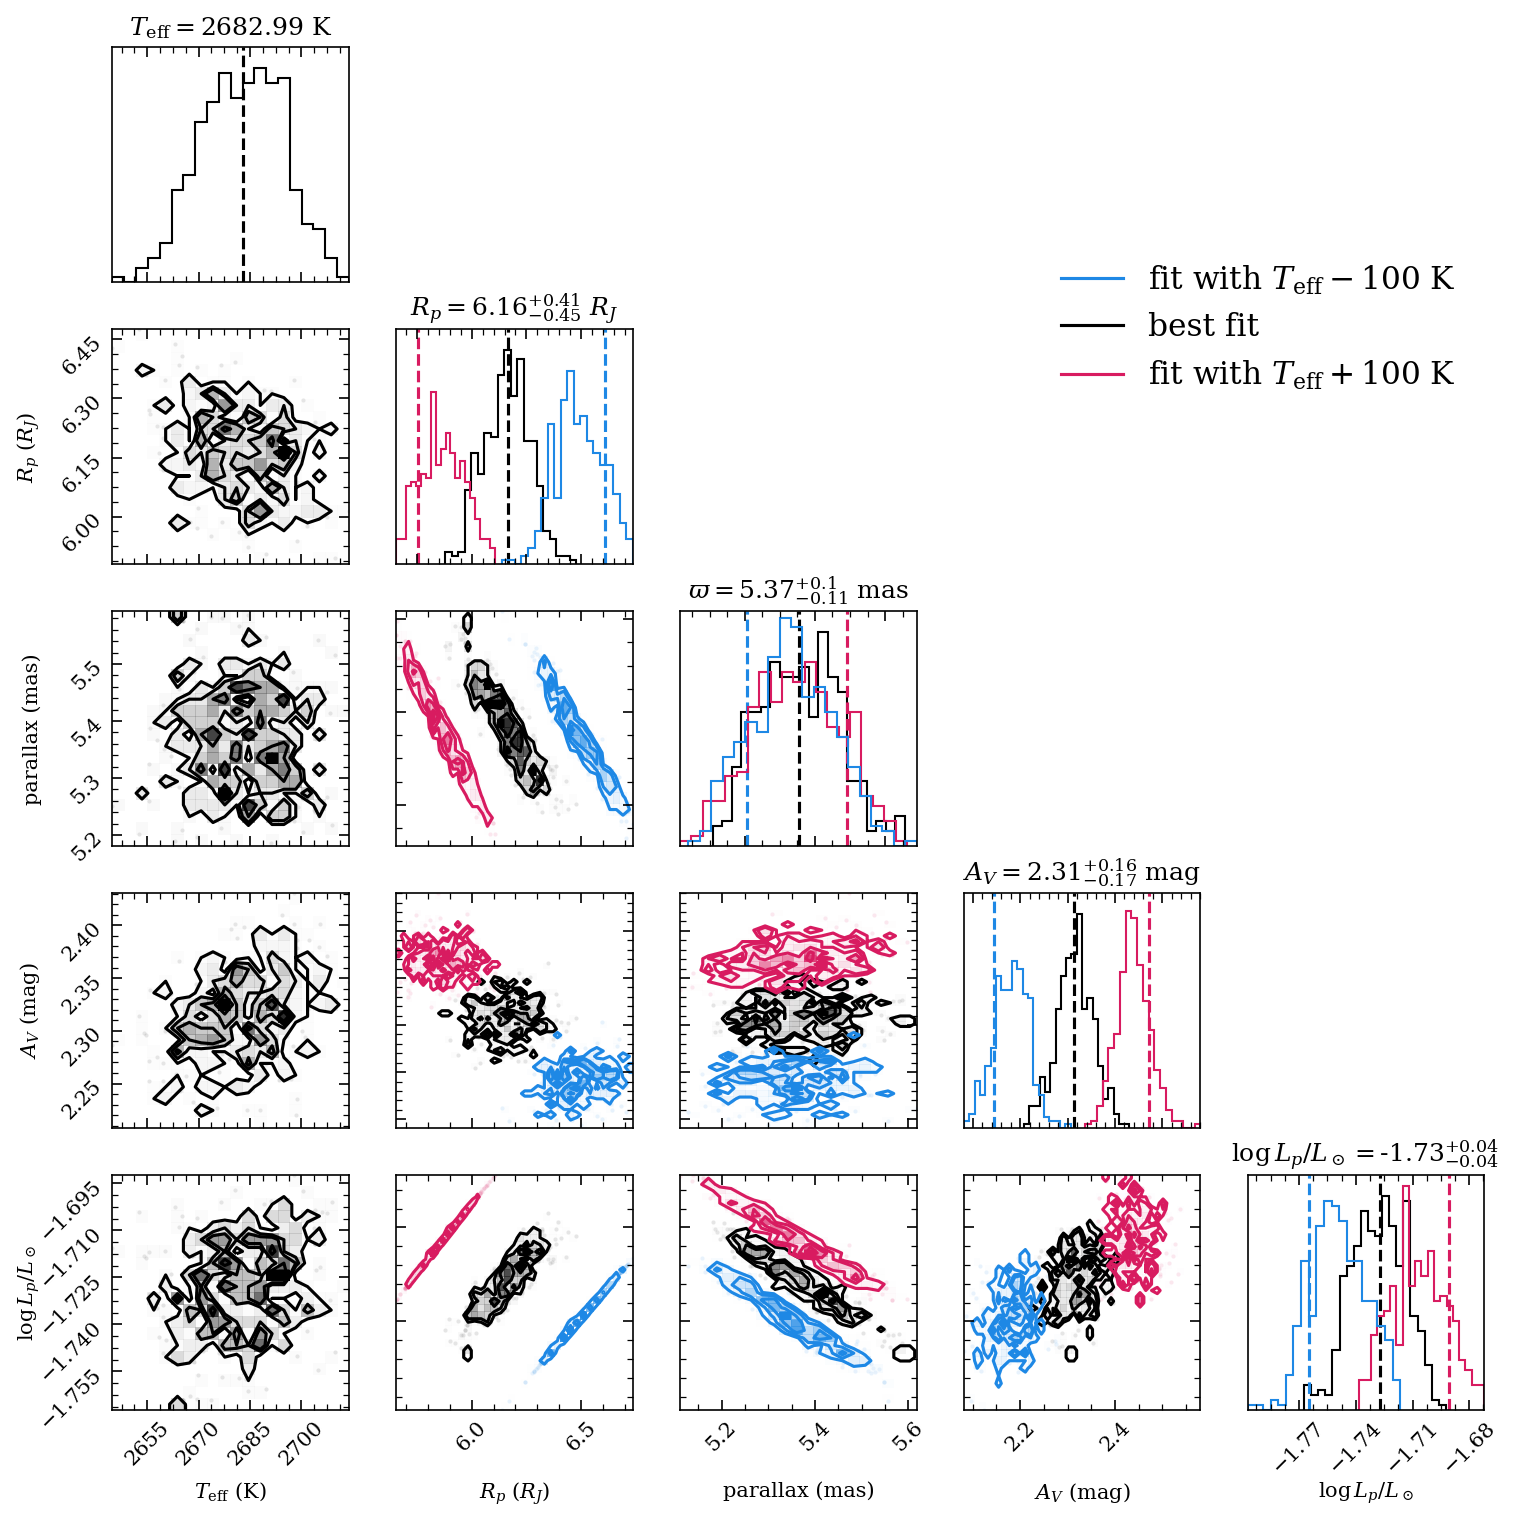

In [17]:
fs.plot_error_corner(plus_samples, plus_vals, minus_samples, minus_vals)

## Finally, we save our best fit model and best fit parameters 

In [18]:
fs.save_bestfit_model()
fs.save_bestfit_parameters(plus_vals, minus_vals)


---------------------
Get median parameters
---------------------

Database tag: 2MASS J11011926-7732383

Parameters:
   - radius = 6.48
   - parallax = 5.35
   - ext_av = 2.18
   - teff = 2582.99
   - logg = 4.00
saving best fit model to:  2MASS_J11011926-7732383_BTSettl_bestfit_spectra_T2582_logg4.0_Av2.2.txt
save best fit parameters to:  2MASS_J11011926-7732383_BTSettl_bestfit_parameters.csv
